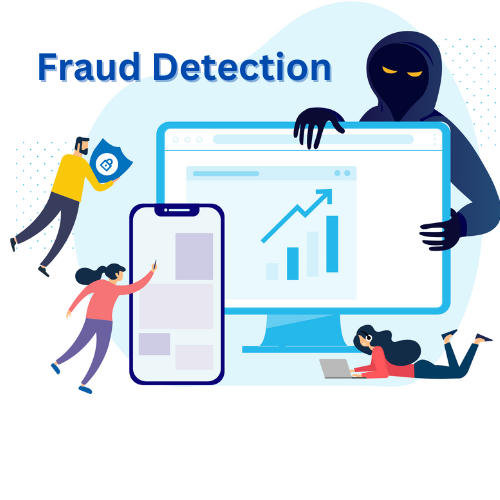

# Problem Statement: 


 PredCatch Analytics' Australian banking client's profitability and reputation are being hit by fraudulent ATM transactions. They want PredCatch to help them in reducing and if possible completely eliminating such fraudulent transactions. PredCatch believes it can do the same by building a predictive model to catch such fraudulent transactions in real time and decline them. Your job as PredCatch's Data Scientist is to build this fraud detection & prevention predictive model in the first step. If successful, in the 2nd step you will have to present your solutions and explain how it works to the client. The data has been made available to you. 
The challenging part of the problem is that the data contains very few fraud instances in comparison to the overall population. To give more edge to the solution they have also collected data regarding.
-  <b>[geo_scores] </b>- location of the transactions
-  <b>[Lambda_wts] </b>- their own proprietary index
- <b>[Qset_tats] </b>- on network turn around times ( Transaction time )
- <b>[instance_scores] </b> - vulnerability qualification score ( cibil scores )

Training data contains masked variables pertaining to each transaction id . 

prediction target here is 'Target' .

1: Fraudulent transactions
0: Clean transactions

## Importing Libraries

In [5]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

# Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

## Importing Datasets

In [6]:
geo = pd.read_csv('Geo_scores.csv')
instance = pd.read_csv('instance_scores.csv')
lambdawts = pd.read_csv('Lambda_wts.csv')
qset = pd.read_csv('Qset_tats.csv')
test = pd.read_csv('test_share.csv')
train = pd.read_csv('train.csv')

# Dataset Information

In [7]:
datasets = [geo, instance, lambdawts, qset, test, train]
names = ["geo_scores", "instance_scores", "lambdawts", "qset", "test", "train"]

# ANSI escape code for bold text
bold_text = "\033[1m"
# ANSI escape code to reset text formatting
reset_text = "\033[0m"

for name, dataset in zip(names, datasets):
    # Print shape
    print(f"{bold_text} {name} shape:{reset_text} {dataset.shape}")
    print("---------" * 10)
    
    # Print head
    print(f"{bold_text}{name} head:{reset_text}")
    print(dataset.head())
    print("---------" * 10)

 geo_scores shape: (1424035, 2)
------------------------------------------------------------------------------------------
geo_scores head:
       id  geo_score
0   26674       4.48
1  204314       4.48
2  176521       5.17
3   48812      -2.41
4  126870       6.55
------------------------------------------------------------------------------------------
 instance_scores shape: (1424035, 2)
------------------------------------------------------------------------------------------
instance_scores head:
       id  instance_scores
0  173444            -0.88
1  259378             1.50
2  161170             0.44
3  191161             0.76
4   34521            -0.84
------------------------------------------------------------------------------------------
 lambdawts shape: (1400, 2)
------------------------------------------------------------------------------------------
lambdawts head:
     Group  lambda_wt
0   Grp936       3.41
1   Grp347      -2.88
2   Grp188       0.39
3  Grp1053      -

In [8]:
for name, dataset in zip(names, datasets):
    # Print dataset info
    print(f"* Information of {bold_text}{name}:{reset_text}")
    print("-------" * 10)
    dataset.info()
    print("-------" * 10)


* Information of geo_scores:
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424035 entries, 0 to 1424034
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   id         1424035 non-null  int64  
 1   geo_score  1352492 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 21.7 MB
----------------------------------------------------------------------
* Information of instance_scores:
----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424035 entries, 0 to 1424034
Data columns (total 2 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1424035 non-null  int64  
 1   instance_scores  1424035 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 21.7 MB
--------------------------------------

# Data Preprocessing

### - Checking for Duplicates 

In [9]:
for name, dataset in zip(names, datasets):
    print(f"* Duplicated values in {bold_text}{name}:{reset_text}",dataset.duplicated().sum())
    print("---------" * 10)

* Duplicated values in geo_scores: 55349
------------------------------------------------------------------------------------------
* Duplicated values in instance_scores: 33600
------------------------------------------------------------------------------------------
* Duplicated values in lambdawts: 0
------------------------------------------------------------------------------------------
* Duplicated values in qset: 59311
------------------------------------------------------------------------------------------
* Duplicated values in test: 0
------------------------------------------------------------------------------------------
* Duplicated values in train: 0
------------------------------------------------------------------------------------------


### - Checking for Missing Values

In [10]:
for name, dataset in zip(names, datasets):
    missing_values = dataset.isnull().sum()
    
    print(f"* Details of Missing values in {bold_text}{name}:{reset_text}")
    print("---------" * 10)
    print(missing_values if not missing_values.empty else "No missing values found.")
    print("---------" * 10)


* Details of Missing values in geo_scores:
------------------------------------------------------------------------------------------
id               0
geo_score    71543
dtype: int64
------------------------------------------------------------------------------------------
* Details of Missing values in instance_scores:
------------------------------------------------------------------------------------------
id                 0
instance_scores    0
dtype: int64
------------------------------------------------------------------------------------------
* Details of Missing values in lambdawts:
------------------------------------------------------------------------------------------
Group        0
lambda_wt    0
dtype: int64
------------------------------------------------------------------------------------------
* Details of Missing values in qset:
------------------------------------------------------------------------------------------
id                           0
qsets_normali

In [11]:
# checking the missing values percentages

geo.isnull().sum()/len(geo)*100

id           0.000000
geo_score    5.023964
dtype: float64

In [12]:
geo.describe()

,id,geo_score
count,1.424035e+06,1.352492e+06
mean,1.424030e+05,-9.279168e-06
std,8.221673e+04,7.827199e+00
min,0.000000e+00,-1.093900e+02
25%,7.120100e+04,-5.860000e+00
50%,1.424030e+05,1.800000e-01
75%,2.136050e+05,5.860000e+00
max,2.848060e+05,4.581000e+01


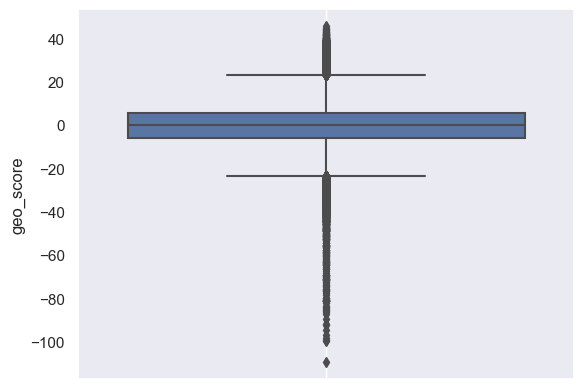

In [13]:
sns.boxplot(y='geo_score', data=geo) 
plt.grid();

In [14]:
geo['geo_score'] = geo['geo_score'].fillna(geo['geo_score'].median())

In [15]:
geo['geo_score'].isnull().sum() 

0

In [16]:
qset.isnull().sum()/len(qset)*100

id                      0.000000
qsets_normalized_tat    7.247083
dtype: float64

In [17]:
qset.describe()

,id,qsets_normalized_tat
count,1.424035e+06,1.320834e+06
mean,1.424030e+05,1.094006e-05
std,8.221673e+04,7.731794e+00
min,0.000000e+00,-1.404400e+02
25%,7.120100e+04,-5.860000e+00
50%,1.424030e+05,2.000000e-02
75%,2.136050e+05,5.860000e+00
max,2.848060e+05,6.110000e+01


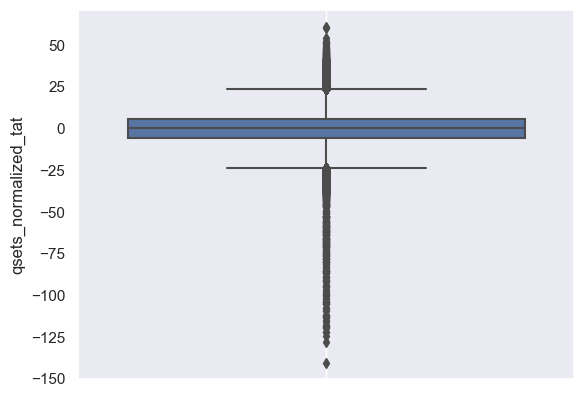

In [18]:
sns.boxplot(y='qsets_normalized_tat', data=qset)
plt.grid();

In [19]:
qset['qsets_normalized_tat'] = qset['qsets_normalized_tat'].fillna(qset['qsets_normalized_tat'].median())

In [20]:
qset['qsets_normalized_tat'].isnull().sum()

0

### - Checking for duplicated values

In [21]:
for name, dataset in zip(names, datasets):
    duplicate_values = dataset.duplicated().sum()
    
    print(f"* Details of Duplicated values in {bold_text}{name}:{reset_text}{duplicate_values}")
    print("-------" * 10)

* Details of Duplicated values in geo_scores:55349
----------------------------------------------------------------------
* Details of Duplicated values in instance_scores:33600
----------------------------------------------------------------------
* Details of Duplicated values in lambdawts:0
----------------------------------------------------------------------
* Details of Duplicated values in qset:59314
----------------------------------------------------------------------
* Details of Duplicated values in test:0
----------------------------------------------------------------------
* Details of Duplicated values in train:0
----------------------------------------------------------------------


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              227845 non-null  int64  
 1   Group           227845 non-null  object 
 2   Per1            227845 non-null  float64
 3   Per2            227845 non-null  float64
 4   Per3            227845 non-null  float64
 5   Per4            227845 non-null  float64
 6   Per5            227845 non-null  float64
 7   Per6            227845 non-null  float64
 8   Per7            227845 non-null  float64
 9   Per8            227845 non-null  float64
 10  Per9            227845 non-null  float64
 11  Dem1            227845 non-null  float64
 12  Dem2            227845 non-null  float64
 13  Dem3            227845 non-null  float64
 14  Dem4            227845 non-null  float64
 15  Dem5            227845 non-null  float64
 16  Dem6            227845 non-null  float64
 17  Dem7      

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56962 entries, 0 to 56961
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              56962 non-null  int64  
 1   Group           56962 non-null  object 
 2   Per1            56962 non-null  float64
 3   Per2            56962 non-null  float64
 4   Per3            56962 non-null  float64
 5   Per4            56962 non-null  float64
 6   Per5            56962 non-null  float64
 7   Per6            56962 non-null  float64
 8   Per7            56962 non-null  float64
 9   Per8            56962 non-null  float64
 10  Per9            56962 non-null  float64
 11  Dem1            56962 non-null  float64
 12  Dem2            56962 non-null  float64
 13  Dem3            56962 non-null  float64
 14  Dem4            56962 non-null  float64
 15  Dem5            56962 non-null  float64
 16  Dem6            56962 non-null  float64
 17  Dem7            56962 non-null 

In [24]:
print("geo id :", geo['id'].nunique())
print("-------"*10)
print("instance id:", instance['id'].nunique())
print("-------"*10)
print("lambdawts Group :", lambdawts['Group'].nunique())
print("-------"*10)
print("qset id :", qset['id'].nunique())
print("-------"*10)
print("test - id :", test['id'].nunique())
print("-------"*10)
print("test - Group :", test['Group'].nunique())
print("-------"*10)
print("train - id :", train['id'].nunique())
print("-------"*10)
print("train - Group :", train['Group'].nunique())

geo id : 284807
----------------------------------------------------------------------
instance id: 284807
----------------------------------------------------------------------
lambdawts Group : 1400
----------------------------------------------------------------------
qset id : 284807
----------------------------------------------------------------------
test - id : 56962
----------------------------------------------------------------------
test - Group : 915
----------------------------------------------------------------------
train - id : 227845
----------------------------------------------------------------------
train - Group : 1301


- geo_scores,instance_scores and Qset_stats have similar number of unique ids = <b>284807</b>
- Train has <b>227845</b> number of unique ids. 
- Test has <b>56962</b> number of unique ids.
- combining id column of Train and Test : <b>227845 + 56962 = 284807</b> unique transactions ids.
- combining Group column of Train and Test : <b>915 + 1301 = 1406 </b>

In [25]:
print(train.shape)
print(test.shape)

(227845, 28)
(56962, 27)


In [26]:
total_rows = train.shape[0] + test.shape[0]

print(f"Combining the Train and Test : {bold_text}{total_rows}{reset_text}")

Combining the Train and Test : 284807


In [27]:
train['data'] ='train'
test['data'] = 'test'      #to recognize the train and test data

In [28]:
all_data = pd.concat([train, test], axis=0)  #combine the train and test data

In [29]:
all_data.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data
0,112751,Grp169,1.070000,0.580000,0.480000,0.766667,1.233333,1.993333,0.340000,1.010000,0.863333,0.460000,0.643333,0.736667,0.756667,0.813333,0.693333,0.666667,0.680000,0.726667,0.606667,1.010000,0.933333,0.603333,0.686667,0.673333,-245.7500,0.0,train
1,18495,Grp161,0.473333,1.206667,0.883333,1.430000,0.726667,0.626667,0.810000,0.783333,0.190000,0.470000,0.613333,0.883333,0.653333,0.463333,0.483333,0.583333,0.716667,0.743333,0.680000,0.690000,0.560000,0.670000,0.553333,0.653333,-248.0000,0.0,train
2,23915,Grp261,1.130000,0.143333,0.946667,0.123333,0.080000,0.836667,0.056667,0.756667,0.226667,0.660000,0.730000,0.873333,0.923333,1.223333,0.686667,0.606667,0.690000,0.820000,0.600000,0.383333,0.763333,0.670000,0.686667,0.673333,-233.1250,0.0,train
3,50806,Grp198,0.636667,1.090000,0.750000,0.940000,0.743333,0.346667,0.956667,0.633333,0.486667,1.096667,0.466667,0.670000,0.526667,0.783333,0.856667,0.716667,0.720000,0.900000,0.680000,0.846667,0.423333,0.520000,0.846667,0.760000,-249.7775,0.0,train
4,184244,Grp228,0.560000,1.013333,0.593333,0.416667,0.773333,0.460000,0.853333,0.796667,0.516667,0.756667,0.683333,0.296667,0.780000,0.636667,0.783333,0.630000,0.603333,0.486667,0.693333,0.526667,0.520000,0.716667,0.706667,0.673333,-247.5775,0.0,train


In [30]:
all_data.tail()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data
56957,18333,Grp102,0.553333,1.043333,1.096667,0.686667,0.673333,0.340000,0.900000,0.643333,0.543333,0.586667,0.660000,0.970000,0.796667,0.626667,0.636667,0.700000,0.576667,0.433333,0.660000,0.776667,0.610000,0.690000,0.750000,0.700000,-249.5050,NaN,test
56958,244207,Grp504,1.353333,0.616667,0.276667,0.783333,0.690000,0.650000,0.473333,0.670000,1.023333,0.293333,0.940000,0.896667,0.983333,0.936667,0.576667,0.643333,0.713333,0.870000,0.683333,0.690000,0.640000,0.883333,0.663333,0.660000,-248.7525,NaN,test
56959,103277,Grp78,1.083333,0.433333,0.806667,0.490000,0.243333,0.316667,0.533333,0.606667,0.420000,0.480000,0.490000,1.023333,0.310000,0.906667,0.450000,0.536667,0.433333,0.063333,0.753333,0.780000,0.603333,0.880000,0.643333,0.676667,-231.0500,NaN,test
56960,273294,Grp134,0.566667,1.153333,0.370000,0.616667,0.793333,0.226667,0.910000,0.696667,0.600000,0.500000,0.896667,0.876667,0.683333,0.850000,0.573333,0.643333,0.776667,1.026667,0.626667,0.646667,0.566667,0.616667,0.713333,0.706667,-246.3150,NaN,test
56961,223337,Grp18,1.426667,0.110000,-0.006667,-0.200000,0.983333,1.870000,0.033333,0.963333,0.266667,0.586667,0.793333,0.780000,0.493333,0.623333,0.553333,0.543333,0.616667,0.670000,0.770000,0.893333,0.586667,0.616667,0.683333,0.650000,-248.4500,NaN,test


In [31]:
all_data.isnull().sum()

id                    0
Group                 0
Per1                  0
Per2                  0
Per3                  0
Per4                  0
Per5                  0
Per6                  0
Per7                  0
Per8                  0
Per9                  0
Dem1                  0
Dem2                  0
Dem3                  0
Dem4                  0
Dem5                  0
Dem6                  0
Dem7                  0
Dem8                  0
Dem9                  0
Cred1                 0
Cred2                 0
Cred3                 0
Cred4                 0
Cred5                 0
Cred6                 0
Normalised_FNT        0
Target            56962
data                  0
dtype: int64

In [32]:
all_data.shape

(284807, 29)

- Joining all the Datasets one by one who is having <b>same id</b> and <b>same Group</b>

In [33]:
geo.shape 

(1424035, 2)

In [34]:
geo.head() 

,id,geo_score
0,26674,4.48
1,204314,4.48
2,176521,5.17
3,48812,-2.41
4,126870,6.55


In [35]:
geo = geo.groupby('id').mean() 

In [36]:
all_data = pd.merge(all_data, geo, on='id', how='left')

In [37]:
all_data.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data,geo_score
0,112751,Grp169,1.070000,0.580000,0.480000,0.766667,1.233333,1.993333,0.340000,1.010000,0.863333,0.460000,0.643333,0.736667,0.756667,0.813333,0.693333,0.666667,0.680000,0.726667,0.606667,1.010000,0.933333,0.603333,0.686667,0.673333,-245.7500,0.0,train,0.256
1,18495,Grp161,0.473333,1.206667,0.883333,1.430000,0.726667,0.626667,0.810000,0.783333,0.190000,0.470000,0.613333,0.883333,0.653333,0.463333,0.483333,0.583333,0.716667,0.743333,0.680000,0.690000,0.560000,0.670000,0.553333,0.653333,-248.0000,0.0,train,-0.250
2,23915,Grp261,1.130000,0.143333,0.946667,0.123333,0.080000,0.836667,0.056667,0.756667,0.226667,0.660000,0.730000,0.873333,0.923333,1.223333,0.686667,0.606667,0.690000,0.820000,0.600000,0.383333,0.763333,0.670000,0.686667,0.673333,-233.1250,0.0,train,-0.950
3,50806,Grp198,0.636667,1.090000,0.750000,0.940000,0.743333,0.346667,0.956667,0.633333,0.486667,1.096667,0.466667,0.670000,0.526667,0.783333,0.856667,0.716667,0.720000,0.900000,0.680000,0.846667,0.423333,0.520000,0.846667,0.760000,-249.7775,0.0,train,0.490
4,184244,Grp228,0.560000,1.013333,0.593333,0.416667,0.773333,0.460000,0.853333,0.796667,0.516667,0.756667,0.683333,0.296667,0.780000,0.636667,0.783333,0.630000,0.603333,0.486667,0.693333,0.526667,0.520000,0.716667,0.706667,0.673333,-247.5775,0.0,train,0.850


In [38]:
all_data.shape

(284807, 30)

In [39]:
instance['id'].nunique()

284807

In [40]:
instance.shape

(1424035, 2)

In [41]:
instance = instance.groupby('id').mean()

In [42]:
instance.shape

(284807, 1)

In [43]:
all_data = pd.merge(all_data, instance, on='id', how='left')

In [44]:
all_data.shape

(284807, 31)

In [45]:
all_data.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data,geo_score,instance_scores
0,112751,Grp169,1.070000,0.580000,0.480000,0.766667,1.233333,1.993333,0.340000,1.010000,0.863333,0.460000,0.643333,0.736667,0.756667,0.813333,0.693333,0.666667,0.680000,0.726667,0.606667,1.010000,0.933333,0.603333,0.686667,0.673333,-245.7500,0.0,train,0.256,-0.06
1,18495,Grp161,0.473333,1.206667,0.883333,1.430000,0.726667,0.626667,0.810000,0.783333,0.190000,0.470000,0.613333,0.883333,0.653333,0.463333,0.483333,0.583333,0.716667,0.743333,0.680000,0.690000,0.560000,0.670000,0.553333,0.653333,-248.0000,0.0,train,-0.250,0.52
2,23915,Grp261,1.130000,0.143333,0.946667,0.123333,0.080000,0.836667,0.056667,0.756667,0.226667,0.660000,0.730000,0.873333,0.923333,1.223333,0.686667,0.606667,0.690000,0.820000,0.600000,0.383333,0.763333,0.670000,0.686667,0.673333,-233.1250,0.0,train,-0.950,1.56
3,50806,Grp198,0.636667,1.090000,0.750000,0.940000,0.743333,0.346667,0.956667,0.633333,0.486667,1.096667,0.466667,0.670000,0.526667,0.783333,0.856667,0.716667,0.720000,0.900000,0.680000,0.846667,0.423333,0.520000,0.846667,0.760000,-249.7775,0.0,train,0.490,0.70
4,184244,Grp228,0.560000,1.013333,0.593333,0.416667,0.773333,0.460000,0.853333,0.796667,0.516667,0.756667,0.683333,0.296667,0.780000,0.636667,0.783333,0.630000,0.603333,0.486667,0.693333,0.526667,0.520000,0.716667,0.706667,0.673333,-247.5775,0.0,train,0.850,-0.47


In [46]:
lambdawts['Group'].nunique()

1400

In [47]:
lambdawts.shape

(1400, 2)

In [48]:
all_data.shape

(284807, 31)

In [49]:
all_data['Group'].nunique()

1400

In [50]:
all_data = pd.merge(all_data, lambdawts, on='Group', how='left')

In [51]:
all_data.shape

(284807, 32)

In [52]:
all_data.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data,geo_score,instance_scores,lambda_wt
0,112751,Grp169,1.070000,0.580000,0.480000,0.766667,1.233333,1.993333,0.340000,1.010000,0.863333,0.460000,0.643333,0.736667,0.756667,0.813333,0.693333,0.666667,0.680000,0.726667,0.606667,1.010000,0.933333,0.603333,0.686667,0.673333,-245.7500,0.0,train,0.256,-0.06,-0.13
1,18495,Grp161,0.473333,1.206667,0.883333,1.430000,0.726667,0.626667,0.810000,0.783333,0.190000,0.470000,0.613333,0.883333,0.653333,0.463333,0.483333,0.583333,0.716667,0.743333,0.680000,0.690000,0.560000,0.670000,0.553333,0.653333,-248.0000,0.0,train,-0.250,0.52,0.66
2,23915,Grp261,1.130000,0.143333,0.946667,0.123333,0.080000,0.836667,0.056667,0.756667,0.226667,0.660000,0.730000,0.873333,0.923333,1.223333,0.686667,0.606667,0.690000,0.820000,0.600000,0.383333,0.763333,0.670000,0.686667,0.673333,-233.1250,0.0,train,-0.950,1.56,-0.51
3,50806,Grp198,0.636667,1.090000,0.750000,0.940000,0.743333,0.346667,0.956667,0.633333,0.486667,1.096667,0.466667,0.670000,0.526667,0.783333,0.856667,0.716667,0.720000,0.900000,0.680000,0.846667,0.423333,0.520000,0.846667,0.760000,-249.7775,0.0,train,0.490,0.70,0.72
4,184244,Grp228,0.560000,1.013333,0.593333,0.416667,0.773333,0.460000,0.853333,0.796667,0.516667,0.756667,0.683333,0.296667,0.780000,0.636667,0.783333,0.630000,0.603333,0.486667,0.693333,0.526667,0.520000,0.716667,0.706667,0.673333,-247.5775,0.0,train,0.850,-0.47,0.60


In [53]:
qset['id'].nunique()

284807

In [54]:
qset.shape

(1424035, 2)

In [55]:
qset = qset.groupby('id').mean()

In [56]:
qset.shape

(284807, 1)

In [57]:
all_data = pd.merge(all_data, qset, on='id', how='left')

In [58]:
all_data.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data,geo_score,instance_scores,lambda_wt,qsets_normalized_tat
0,112751,Grp169,1.070000,0.580000,0.480000,0.766667,1.233333,1.993333,0.340000,1.010000,0.863333,0.460000,0.643333,0.736667,0.756667,0.813333,0.693333,0.666667,0.680000,0.726667,0.606667,1.010000,0.933333,0.603333,0.686667,0.673333,-245.7500,0.0,train,0.256,-0.06,-0.13,-0.700
1,18495,Grp161,0.473333,1.206667,0.883333,1.430000,0.726667,0.626667,0.810000,0.783333,0.190000,0.470000,0.613333,0.883333,0.653333,0.463333,0.483333,0.583333,0.716667,0.743333,0.680000,0.690000,0.560000,0.670000,0.553333,0.653333,-248.0000,0.0,train,-0.250,0.52,0.66,0.140
2,23915,Grp261,1.130000,0.143333,0.946667,0.123333,0.080000,0.836667,0.056667,0.756667,0.226667,0.660000,0.730000,0.873333,0.923333,1.223333,0.686667,0.606667,0.690000,0.820000,0.600000,0.383333,0.763333,0.670000,0.686667,0.673333,-233.1250,0.0,train,-0.950,1.56,-0.51,-0.430
3,50806,Grp198,0.636667,1.090000,0.750000,0.940000,0.743333,0.346667,0.956667,0.633333,0.486667,1.096667,0.466667,0.670000,0.526667,0.783333,0.856667,0.716667,0.720000,0.900000,0.680000,0.846667,0.423333,0.520000,0.846667,0.760000,-249.7775,0.0,train,0.490,0.70,0.72,-0.302
4,184244,Grp228,0.560000,1.013333,0.593333,0.416667,0.773333,0.460000,0.853333,0.796667,0.516667,0.756667,0.683333,0.296667,0.780000,0.636667,0.783333,0.630000,0.603333,0.486667,0.693333,0.526667,0.520000,0.716667,0.706667,0.673333,-247.5775,0.0,train,0.850,-0.47,0.60,-0.630


In [59]:
all_data.tail()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data,geo_score,instance_scores,lambda_wt,qsets_normalized_tat
284802,18333,Grp102,0.553333,1.043333,1.096667,0.686667,0.673333,0.340000,0.900000,0.643333,0.543333,0.586667,0.660000,0.970000,0.796667,0.626667,0.636667,0.700000,0.576667,0.433333,0.660000,0.776667,0.610000,0.690000,0.750000,0.700000,-249.5050,NaN,test,-0.114,-0.51,-0.40,0.010
284803,244207,Grp504,1.353333,0.616667,0.276667,0.783333,0.690000,0.650000,0.473333,0.670000,1.023333,0.293333,0.940000,0.896667,0.983333,0.936667,0.576667,0.643333,0.713333,0.870000,0.683333,0.690000,0.640000,0.883333,0.663333,0.660000,-248.7525,NaN,test,0.110,-0.46,-1.54,0.064
284804,103277,Grp78,1.083333,0.433333,0.806667,0.490000,0.243333,0.316667,0.533333,0.606667,0.420000,0.480000,0.490000,1.023333,0.310000,0.906667,0.450000,0.536667,0.433333,0.063333,0.753333,0.780000,0.603333,0.880000,0.643333,0.676667,-231.0500,NaN,test,-0.530,0.65,0.29,-0.020
284805,273294,Grp134,0.566667,1.153333,0.370000,0.616667,0.793333,0.226667,0.910000,0.696667,0.600000,0.500000,0.896667,0.876667,0.683333,0.850000,0.573333,0.643333,0.776667,1.026667,0.626667,0.646667,0.566667,0.616667,0.713333,0.706667,-246.3150,NaN,test,0.270,-0.92,-0.69,0.610
284806,223337,Grp18,1.426667,0.110000,-0.006667,-0.200000,0.983333,1.870000,0.033333,0.963333,0.266667,0.586667,0.793333,0.780000,0.493333,0.623333,0.553333,0.543333,0.616667,0.670000,0.770000,0.893333,0.586667,0.616667,0.683333,0.650000,-248.4500,NaN,test,-0.664,1.57,-0.37,0.354


In [60]:
# split the train and test data seperately
train = all_data[all_data['data']=='train']
test = all_data[all_data['data']=='test']

In [61]:
print(train.shape)
print(test.shape)

(227845, 33)
(56962, 33)


In [62]:
# Target - train dataset
train.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data,geo_score,instance_scores,lambda_wt,qsets_normalized_tat
0,112751,Grp169,1.070000,0.580000,0.480000,0.766667,1.233333,1.993333,0.340000,1.010000,0.863333,0.460000,0.643333,0.736667,0.756667,0.813333,0.693333,0.666667,0.680000,0.726667,0.606667,1.010000,0.933333,0.603333,0.686667,0.673333,-245.7500,0.0,train,0.256,-0.06,-0.13,-0.700
1,18495,Grp161,0.473333,1.206667,0.883333,1.430000,0.726667,0.626667,0.810000,0.783333,0.190000,0.470000,0.613333,0.883333,0.653333,0.463333,0.483333,0.583333,0.716667,0.743333,0.680000,0.690000,0.560000,0.670000,0.553333,0.653333,-248.0000,0.0,train,-0.250,0.52,0.66,0.140
2,23915,Grp261,1.130000,0.143333,0.946667,0.123333,0.080000,0.836667,0.056667,0.756667,0.226667,0.660000,0.730000,0.873333,0.923333,1.223333,0.686667,0.606667,0.690000,0.820000,0.600000,0.383333,0.763333,0.670000,0.686667,0.673333,-233.1250,0.0,train,-0.950,1.56,-0.51,-0.430
3,50806,Grp198,0.636667,1.090000,0.750000,0.940000,0.743333,0.346667,0.956667,0.633333,0.486667,1.096667,0.466667,0.670000,0.526667,0.783333,0.856667,0.716667,0.720000,0.900000,0.680000,0.846667,0.423333,0.520000,0.846667,0.760000,-249.7775,0.0,train,0.490,0.70,0.72,-0.302
4,184244,Grp228,0.560000,1.013333,0.593333,0.416667,0.773333,0.460000,0.853333,0.796667,0.516667,0.756667,0.683333,0.296667,0.780000,0.636667,0.783333,0.630000,0.603333,0.486667,0.693333,0.526667,0.520000,0.716667,0.706667,0.673333,-247.5775,0.0,train,0.850,-0.47,0.60,-0.630


In [63]:
Fraud = train[train['Target']==1]
Valid = train[train['Target']==0]
outlier_fraction = (len(Fraud)/(len(train)))*100
print(outlier_fraction)

0.17292457591783889


In [64]:
print(len(Fraud))
print(len(Valid))

394
227451


In [65]:
x = train.drop(['id','Group','Target','data'], axis=1)
y = train[['Target']]

In [66]:
x.head()

,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,geo_score,instance_scores,lambda_wt,qsets_normalized_tat
0,1.070000,0.580000,0.480000,0.766667,1.233333,1.993333,0.340000,1.010000,0.863333,0.460000,0.643333,0.736667,0.756667,0.813333,0.693333,0.666667,0.680000,0.726667,0.606667,1.010000,0.933333,0.603333,0.686667,0.673333,-245.7500,0.256,-0.06,-0.13,-0.700
1,0.473333,1.206667,0.883333,1.430000,0.726667,0.626667,0.810000,0.783333,0.190000,0.470000,0.613333,0.883333,0.653333,0.463333,0.483333,0.583333,0.716667,0.743333,0.680000,0.690000,0.560000,0.670000,0.553333,0.653333,-248.0000,-0.250,0.52,0.66,0.140
2,1.130000,0.143333,0.946667,0.123333,0.080000,0.836667,0.056667,0.756667,0.226667,0.660000,0.730000,0.873333,0.923333,1.223333,0.686667,0.606667,0.690000,0.820000,0.600000,0.383333,0.763333,0.670000,0.686667,0.673333,-233.1250,-0.950,1.56,-0.51,-0.430
3,0.636667,1.090000,0.750000,0.940000,0.743333,0.346667,0.956667,0.633333,0.486667,1.096667,0.466667,0.670000,0.526667,0.783333,0.856667,0.716667,0.720000,0.900000,0.680000,0.846667,0.423333,0.520000,0.846667,0.760000,-249.7775,0.490,0.70,0.72,-0.302
4,0.560000,1.013333,0.593333,0.416667,0.773333,0.460000,0.853333,0.796667,0.516667,0.756667,0.683333,0.296667,0.780000,0.636667,0.783333,0.630000,0.603333,0.486667,0.693333,0.526667,0.520000,0.716667,0.706667,0.673333,-247.5775,0.850,-0.47,0.60,-0.630


In [67]:
y.head()

,Target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [68]:
# Test dataset
test.head()

,id,Group,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,Target,data,geo_score,instance_scores,lambda_wt,qsets_normalized_tat
227845,146574,Grp229,-0.300000,1.540000,0.220000,-0.280000,0.570000,0.260000,0.700000,1.076667,0.930000,0.156667,0.546667,0.530000,0.876667,0.450000,0.370000,0.786667,0.546667,0.313333,0.703333,0.813333,0.776667,0.796667,0.823333,0.783333,-249.7500,NaN,test,0.25,-0.04,0.76,-0.426
227846,268759,Grp141,0.633333,0.953333,0.810000,0.466667,0.910000,0.253333,1.040000,0.550000,0.543333,0.433333,0.966667,0.760000,0.576667,0.653333,0.553333,0.636667,0.770000,0.993333,0.536667,0.703333,0.806667,0.630000,0.673333,0.673333,-249.8125,NaN,test,0.43,-0.77,0.18,-0.620
227847,59727,Grp188,1.043333,0.740000,0.860000,1.006667,0.583333,0.616667,0.630000,0.686667,0.593333,1.250000,0.826667,0.826667,0.653333,0.663333,0.453333,0.626667,0.756667,0.953333,0.623333,0.753333,0.870000,0.596667,0.680000,0.670000,-248.1200,NaN,test,1.32,0.11,0.39,-0.406
227848,151544,Grp426,1.283333,0.300000,0.576667,0.636667,0.256667,0.543333,0.356667,0.663333,1.156667,1.186667,0.900000,0.433333,0.230000,1.323333,0.403333,0.480000,0.460000,0.260000,0.800000,0.606667,0.456667,0.320000,0.676667,0.660000,-222.9875,NaN,test,-2.11,0.33,1.80,0.374
227849,155008,Grp443,1.186667,0.326667,0.476667,0.866667,0.436667,0.680000,0.476667,0.686667,1.476667,1.213333,0.853333,0.583333,0.850000,1.090000,0.550000,0.706667,0.740000,0.823333,0.670000,0.896667,0.566667,0.546667,0.650000,0.663333,-196.2200,NaN,test,-2.11,-0.37,1.89,-0.130


In [69]:
test = test.drop(['id', 'Group', 'Target', 'data'], axis=1)

In [70]:
test.head()

,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,geo_score,instance_scores,lambda_wt,qsets_normalized_tat
227845,-0.300000,1.540000,0.220000,-0.280000,0.570000,0.260000,0.700000,1.076667,0.930000,0.156667,0.546667,0.530000,0.876667,0.450000,0.370000,0.786667,0.546667,0.313333,0.703333,0.813333,0.776667,0.796667,0.823333,0.783333,-249.7500,0.25,-0.04,0.76,-0.426
227846,0.633333,0.953333,0.810000,0.466667,0.910000,0.253333,1.040000,0.550000,0.543333,0.433333,0.966667,0.760000,0.576667,0.653333,0.553333,0.636667,0.770000,0.993333,0.536667,0.703333,0.806667,0.630000,0.673333,0.673333,-249.8125,0.43,-0.77,0.18,-0.620
227847,1.043333,0.740000,0.860000,1.006667,0.583333,0.616667,0.630000,0.686667,0.593333,1.250000,0.826667,0.826667,0.653333,0.663333,0.453333,0.626667,0.756667,0.953333,0.623333,0.753333,0.870000,0.596667,0.680000,0.670000,-248.1200,1.32,0.11,0.39,-0.406
227848,1.283333,0.300000,0.576667,0.636667,0.256667,0.543333,0.356667,0.663333,1.156667,1.186667,0.900000,0.433333,0.230000,1.323333,0.403333,0.480000,0.460000,0.260000,0.800000,0.606667,0.456667,0.320000,0.676667,0.660000,-222.9875,-2.11,0.33,1.80,0.374
227849,1.186667,0.326667,0.476667,0.866667,0.436667,0.680000,0.476667,0.686667,1.476667,1.213333,0.853333,0.583333,0.850000,1.090000,0.550000,0.706667,0.740000,0.823333,0.670000,0.896667,0.566667,0.546667,0.650000,0.663333,-196.2200,-2.11,-0.37,1.89,-0.130


In [71]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227845 entries, 0 to 227844
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Per1                  227845 non-null  float64
 1   Per2                  227845 non-null  float64
 2   Per3                  227845 non-null  float64
 3   Per4                  227845 non-null  float64
 4   Per5                  227845 non-null  float64
 5   Per6                  227845 non-null  float64
 6   Per7                  227845 non-null  float64
 7   Per8                  227845 non-null  float64
 8   Per9                  227845 non-null  float64
 9   Dem1                  227845 non-null  float64
 10  Dem2                  227845 non-null  float64
 11  Dem3                  227845 non-null  float64
 12  Dem4                  227845 non-null  float64
 13  Dem5                  227845 non-null  float64
 14  Dem6                  227845 non-null  float64
 15  

In [72]:
x.describe()

,Per1,Per2,Per3,Per4,Per5,Per6,Per7,Per8,Per9,Dem1,Dem2,Dem3,Dem4,Dem5,Dem6,Dem7,Dem8,Dem9,Cred1,Cred2,Cred3,Cred4,Cred5,Cred6,Normalised_FNT,geo_score,instance_scores,lambda_wt,qsets_normalized_tat
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,0.666006,0.667701,0.666315,0.666687,0.666723,0.667378,0.666934,0.666279,0.666688,0.666576,0.666329,0.666380,0.666871,0.666518,0.666748,0.666394,0.666540,0.666535,0.666684,0.666264,0.666755,0.666878,0.666566,0.666776,-227.954170,0.008908,-0.000123,0.000350,0.001346
std,0.654133,0.548305,0.506357,0.471956,0.461393,0.444573,0.415657,0.401546,0.366537,0.340436,0.332016,0.305384,0.292013,0.279469,0.271590,0.257631,0.244423,0.241902,0.207575,0.202204,0.174204,0.160803,0.135762,0.111612,61.951661,0.997629,1.091488,0.957957,0.850169
min,-18.136667,-23.573333,-15.443333,-1.226667,-37.246667,-8.053333,-13.853333,-23.740000,-3.810000,-0.893333,-1.263333,-0.833333,-3.853333,-2.500000,-0.976667,-17.500000,-10.943333,-2.296667,-14.270000,-0.280000,-2.766667,-0.080000,-6.856667,-4.476667,-250.000000,-18.680000,-24.590000,-19.210000,-25.156000
25%,0.360000,0.470000,0.370000,0.383333,0.436667,0.410000,0.483333,0.596667,0.453333,0.413333,0.450000,0.473333,0.510000,0.500000,0.513333,0.596667,0.590000,0.486667,0.613333,0.546667,0.560000,0.556667,0.643333,0.650000,-248.617500,-0.400000,-0.540000,-0.430000,-0.480000
50%,0.670000,0.690000,0.726667,0.660000,0.650000,0.576667,0.680000,0.673333,0.650000,0.656667,0.663333,0.683333,0.690000,0.666667,0.666667,0.646667,0.656667,0.670000,0.663333,0.680000,0.673333,0.650000,0.666667,0.670000,-244.510000,0.150000,-0.090000,0.050000,-0.066000
75%,1.103333,0.933333,1.010000,0.913333,0.870000,0.800000,0.856667,0.776667,0.866667,0.913333,0.886667,0.883333,0.840000,0.833333,0.820000,0.710000,0.730000,0.843333,0.716667,0.813333,0.783333,0.746667,0.696667,0.693333,-230.750000,0.630000,0.450000,0.490000,0.400000
max,1.483333,8.020000,3.793333,6.163333,12.266667,25.100000,40.863333,7.336667,5.863333,4.673333,3.043333,3.626667,6.440000,2.080000,2.530000,9.413333,9.733333,4.166667,8.176667,2.193333,3.173333,1.840000,11.203333,11.950000,6172.790000,7.850000,23.750000,10.530000,8.540000


In [73]:
x['Normalised_FNT'].describe()  

count    227845.000000
mean       -227.954170
std          61.951661
min        -250.000000
25%        -248.617500
50%        -244.510000
75%        -230.750000
max        6172.790000
Name: Normalised_FNT, dtype: float64

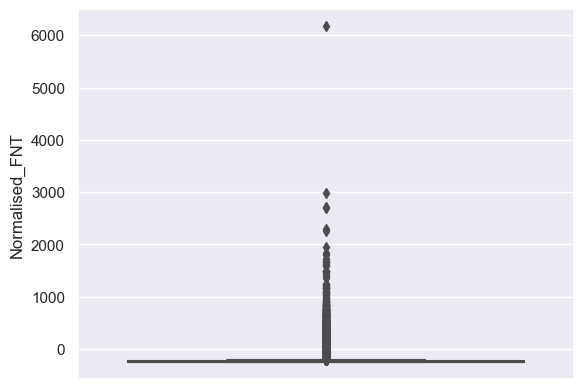

In [74]:
sns.boxplot(y='Normalised_FNT', data=x)
plt.show()

In [75]:
IQR = -230.750000 + 248.617500
IQR

17.867500000000007

In [76]:
# pos_outlier_range = Q3 + 1.5*IQR
pos_outlier_range = -230.750000 + (1.5*IQR)
pos_outlier_range

-203.94875

- Holding capping method right now as positive outlier range is -203.94 which is very less and only few data are above this range

## Feature scaling

In [77]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc_x = sc.fit_transform(x)

In [78]:
pd.DataFrame(sc_x).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
count,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05
mean,2.469880e-16,-1.035354e-16,2.169253e-16,3.414173e-16,-1.947214e-16,-2.275907e-16,7.035416e-17,2.681083e-16,-1.645339e-16,1.437177e-16,-6.576368e-16,-5.469600e-16,5.532282e-16,7.087184e-16,-3.238599e-16,3.898169e-16,1.447624e-16,4.009813e-16,5.466481e-16,5.771474e-16,-3.144731e-16,-2.627054e-16,-1.728916e-16,1.465774e-15,-4.682325e-16,1.871121e-19,4.443913e-18,-9.854572e-18,7.983451e-18
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.874447e+01,-4.421098e+01,-3.181486e+01,-4.011726e+00,-8.217170e+01,-1.961595e+01,-3.493340e+01,-6.078089e+01,-1.221350e+01,-4.582104e+00,-5.811971e+00,-4.910923e+00,-1.547951e+01,-1.133049e+01,-6.051100e+00,-7.051329e+01,-4.749922e+01,-1.224960e+01,-7.195806e+01,-4.679759e+00,-1.970929e+01,-4.644689e+00,-5.541489e+01,-4.608324e+01,-3.558561e-01,-1.873336e+01,-2.252882e+01,-2.005350e+01,-2.959106e+01
25%,-4.678047e-01,-3.605683e-01,-5.851915e-01,-6.003821e-01,-4.986139e-01,-5.789326e-01,-4.417124e-01,-1.733613e-01,-5.820826e-01,-7.438795e-01,-6.515639e-01,-6.321454e-01,-5.372076e-01,-5.958371e-01,-5.648776e-01,-2.706473e-01,-3.131479e-01,-7.435576e-01,-2.570189e-01,-5.914703e-01,-6.128164e-01,-6.853842e-01,-1.711252e-01,-1.503079e-01,-3.335403e-01,-4.098801e-01,-4.946259e-01,-4.492380e-01,-5.661782e-01
50%,6.105872e-03,4.066939e-02,1.191877e-01,-1.416771e-02,-3.624526e-02,-2.040406e-01,3.143566e-02,1.756780e-02,-4.552782e-02,-2.910820e-02,-9.022932e-03,5.551521e-02,7.920522e-02,5.325959e-04,-2.998801e-04,-7.657107e-02,-4.039599e-02,1.432557e-02,-1.614191e-02,6.793120e-02,3.776502e-02,-1.049626e-01,7.443046e-04,2.888425e-02,-2.672385e-01,1.414280e-01,-8.234372e-02,5.182947e-02,-7.921500e-02
75%,6.685615e-01,4.844626e-01,6.787413e-01,5.226069e-01,4.405724e-01,2.983147e-01,4.564670e-01,2.749070e-01,5.455918e-01,7.248287e-01,6.636372e-01,7.104301e-01,5.928826e-01,5.969023e-01,5.642778e-01,1.692588e-01,2.596311e-01,7.308697e-01,2.407935e-01,7.273327e-01,6.692117e-01,4.961884e-01,2.217194e-01,2.379418e-01,-4.512932e-02,6.225696e-01,4.123949e-01,5.111413e-01,4.689126e-01
max,1.249484e+00,1.340918e+01,6.175532e+00,1.164655e+01,2.514117e+01,5.495757e+01,9.670601e+01,1.661179e+01,1.417772e+01,1.176951e+01,7.159325e+00,9.693679e+00,1.977017e+01,5.057748e+00,6.860546e+00,3.395145e+01,3.709477e+01,1.446923e+01,3.617963e+01,7.552138e+00,1.438883e+01,7.295413e+00,7.761210e+01,1.010933e+02,1.033186e+02,7.859741e+00,2.175945e+01,1.099180e+01,1.004350e+01


## Check imbalance dataset

In [79]:
y.value_counts()

Target
0.0       227451
1.0          394
dtype: int64

In [80]:
fraud_per = 394/(394+227451)*100
fraud_per

0.17292457591783889

In [81]:
x.shape

(227845, 29)

In [82]:
# Since data is imbalance, so we can build model with both aproach
# 1) balance the data and perform model building
# 2) model building with balance the data

In [83]:
import imblearn
from imblearn.over_sampling import SMOTE
ros = SMOTE()
x_ros, y_ros = ros.fit_resample(sc_x, y)
print("before data is imbalance")
print(y.value_counts())
print()
print("after balancing the data: ")
print(y_ros.value_counts())

before data is imbalance
Target
0.0       227451
1.0          394
dtype: int64

after balancing the data: 
Target
0.0       227451
1.0       227451
dtype: int64


## Split the data into training and testing for model building

In [84]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_ros, y_ros, test_size=0.25, random_state=101)

# Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(x_train, y_train)

LogisticRegression()

In [86]:
y_pred_train = logit.predict(x_train)
y_pred_test = logit.predict(x_test)

In [87]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [88]:
print(confusion_matrix(y_train, y_pred_train))
print()
print(confusion_matrix(y_test, y_pred_test))

[[165950   4677]
 [ 15655 154894]]

[[55239  1585]
 [ 5258 51644]]


In [89]:
(15477+4647)/(165980+4647+15477+155072)

0.05898421928857833

In [90]:
print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94    170627
         1.0       0.97      0.91      0.94    170549

    accuracy                           0.94    341176
   macro avg       0.94      0.94      0.94    341176
weighted avg       0.94      0.94      0.94    341176


              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     56824
         1.0       0.97      0.91      0.94     56902

    accuracy                           0.94    113726
   macro avg       0.94      0.94      0.94    113726
weighted avg       0.94      0.94      0.94    113726



In [91]:
print(accuracy_score(y_train, y_pred_train))
print()
print(accuracy_score(y_test, y_pred_test))

0.940406124698103

0.9398290628352356


# Decision Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier
dtree= DecisionTreeClassifier(criterion='entropy')
dtree.fit(x_train, y_train)
y_pred_train_dt = dtree.predict(x_train)
y_pred_test_dt = dtree.predict(x_test)
print(accuracy_score(y_train, y_pred_train_dt))
print()
print(accuracy_score(y_test, y_pred_test_dt))

1.0

0.9984524207305278


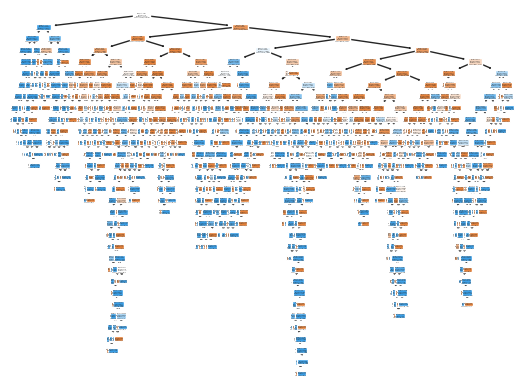

In [93]:
from sklearn import tree
tree.plot_tree(dtree, filled=True)
plt.show()

# RandomForest Classification

In [94]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,criterion='entropy')
rf.fit(x_train, y_train)
y_pred_train_rf = rf.predict(x_train)
y_pred_test_rf = rf.predict(x_test)
print(accuracy_score(y_train, y_pred_train_rf))
print()
print(accuracy_score(y_test, y_pred_test_rf))

1.0

0.9998856901675958


In [95]:
from xgboost import XGBClassifier

# XGBoost Classifier

In [96]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [97]:
y_pred_train_xg = xgb.predict(x_train)
y_pred_test_xg = xgb.predict(x_test)
print(accuracy_score(y_train, y_pred_train_xg))
print()
print(accuracy_score(y_test, y_pred_test_xg))

0.9999970689614744

0.9997362080790673


# Stacking Classifier

In [98]:
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [99]:
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier(criterion='entropy')
clf3 = RandomForestClassifier(n_estimators=100,criterion='entropy')
clf4 = XGBClassifier()
clf5 = GaussianNB()
sclf = StackingClassifier(classifiers=[clf2, clf3, clf4, clf5], meta_classifier=clf1)
print('3-fold cross validation : \n')
for clf, label in zip([clf2, clf3, clf4, clf5, sclf],['Dtree','RForest','XGBoost','Naive_Bayes','StackingClassifier']):
    scores = cross_val_score(clf, x_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy : %0.2f (+/-%0.2f)[%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation : 

Accuracy : 1.00 (+/-0.00)[Dtree]
Accuracy : 1.00 (+/-0.00)[RForest]
Accuracy : 1.00 (+/-0.00)[XGBoost]
Accuracy : 0.91 (+/-0.00)[Naive_Bayes]
Accuracy : nan (+/-nan)[StackingClassifier]


In [100]:
# Anomaly Detection Model
# 1) IsolationForest - RF
# 2) LocalOutlierFector -knn
# 3) OneClassSVM - SVM

In [101]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [102]:
classification = {'IsolationForest' : IsolationForest(contamination=outlier_fraction),
                  "LocalOutlierFactor": LocalOutlierFactor(contamination=outlier_fraction),
                  "OneClassSVM" : OneClassSVM()}

In [103]:
n_outlier = len(Fraud)
n_outlier

394

In [104]:
fraud_percent=len(Fraud)*100/len(x)
print('Percentage of Fraud :',fraud_percent)

Percentage of Fraud : 0.17292457591783889


In [105]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [106]:
x.shape

(227845, 29)

In [107]:
y.shape

(227845, 1)

In [108]:
y.head()

,Target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


## Anamoly Detection:

In [ ]:
for i, (clf_name, clf) in enumerate(classification.items()):
    if clf_name =='LocalOutlierFactor':
        y_pred = clf.fit_predict(x)
        score_prediction = clf.negative_outlier_factor_

    elif clf_name=='OneClassSVM':
        clf.fit(x)
        y_pred = clf.predict(x)

    else:
        clf.fit(x)
        score_prediction = clf.decision_function(x)
        y_pred = clf.predict(x)

    y_pred[y_pred ==1] = 0
    y_pred[y_pred ==-1]= 1
    n_error = (y_pred !=1).sum()

    print("{} : {}".format(clf_name, n_error))
    print()

    print("Accuracy Score :")
    print(accuracy_score(y, y_pred))
    print()

    print("Classification Report :")
    print(classification_report(y, y_pred))

IsolationForest : 188445

Accuracy Score :
0.8284974434374246

Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91    227451
         1.0       0.01      0.91      0.02       394

    accuracy                           0.83    227845
   macro avg       0.50      0.87      0.46    227845
weighted avg       1.00      0.83      0.90    227845

LocalOutlierFactor : 188445

Accuracy Score :
0.8265926397331519

Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91    227451
         1.0       0.00      0.36      0.01       394

    accuracy                           0.83    227845
   macro avg       0.50      0.59      0.46    227845
weighted avg       1.00      0.83      0.90    227845

